# Welcome to the Coral Model Testing and Exploration Notebook!

In this notebook, we take you through examples of running our model the various way to plot the model's outputs.

### We begin with loading the necessary libraries

In [1]:
from coralModelTracking import Organism, Reef, Ocean

import tools as tl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clt

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

### Next, we set out model parameters

In [2]:
## Simulations and Number of runs
NumberOfSimulations = 100
dt=.1
tf=100

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .5
algaePercent = .25

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.9
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent

### Now we create and run multiple reefs

In [3]:
Pacific = Ocean()

for s in range(0,NumberOfSimulations):

    Moorea = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([0,1,2],
                                 p=[coralPercent, turfPercent, algaePercent])
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
            
    Moorea.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    Pacific.append(Moorea)

#### The Products we now can play with
* `Pacific.simulation[1].coralNodeCount`
* `Pacific.simulation[1].coralNeighborCount`

#### Functions to pull information from these objects

Can pull keys and values via:
- `x = list(dictionary.keys())`, and
- `y = list(dictionary.values())`

In running the coralModel, we are interested in capturing the CN index: the average number of coral neighbors for each coral node.

### Single Reef Example, looking at Simulation 1

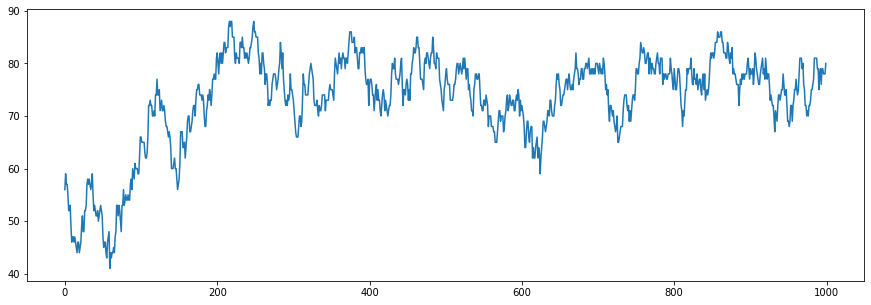

In [4]:
example = Pacific.simulation[1].coralNodeCount
x = list(example.keys())            ## the time steps
coralCount = list(example.values()) ## the number of coral nodes

plt.figure(figsize=(15, 5))
plt.plot(x,coralCount)

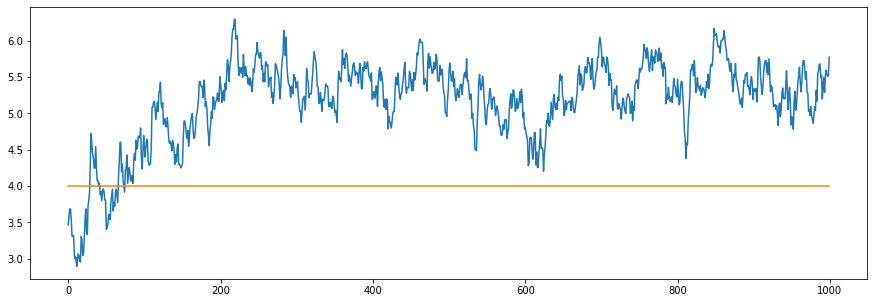

In [5]:
example = Pacific.simulation[1].coralNeighborCount
x = list(example.keys())
CN = np.array(list(example.values()))/np.array(coralCount) ## taking the average of the neighborhood count

plt.figure(figsize=(15, 5))
plt.plot(x,CN)
plt.plot(x,np.repeat(4, NumberOfTimesteps))

Each node can have up to 8 neighbors. If the average is above 4 (the orange line above), this means on average, each coral node is surrounded by more coral than all other benthic types combined.

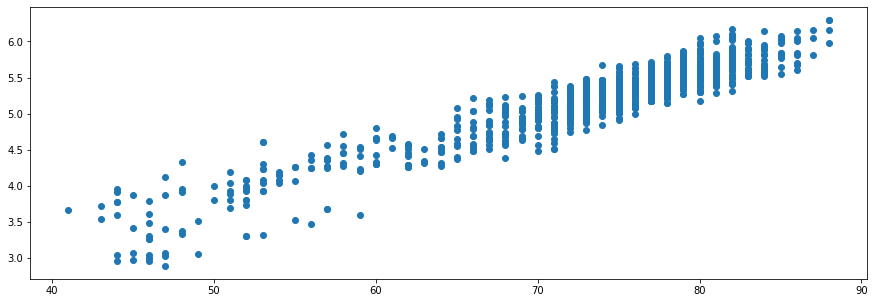

In [6]:
example = Pacific.simulation[1].coralNeighborCount
x = coralCount
y = CN

plt.figure(figsize=(15, 5))
plt.scatter(x,y)

### Looking at the Average across the various simulations

In [7]:
def dictToNumpy(dictionary):
    output = list(dictionary.values())
    output = np.array(output)
    return(output)

multsimCoralCounts = np.array([dictToNumpy(Pacific.simulation[i].coralNodeCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(Pacific.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()

### Coral Node Count: 7 simulations and average of 100 simulations

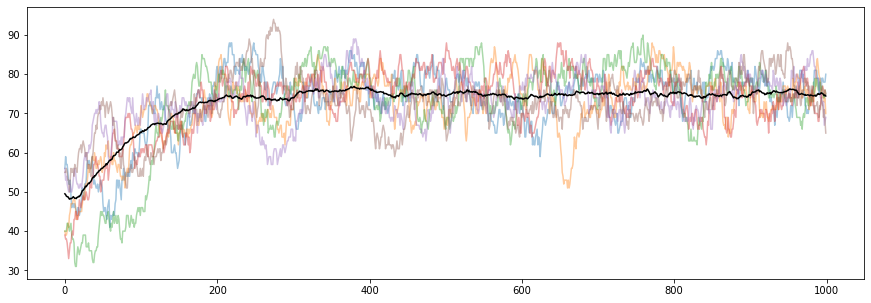

In [10]:
x = list(Pacific.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts[:,1:7], alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### CN index: 7 simulations and average of 100 simulation

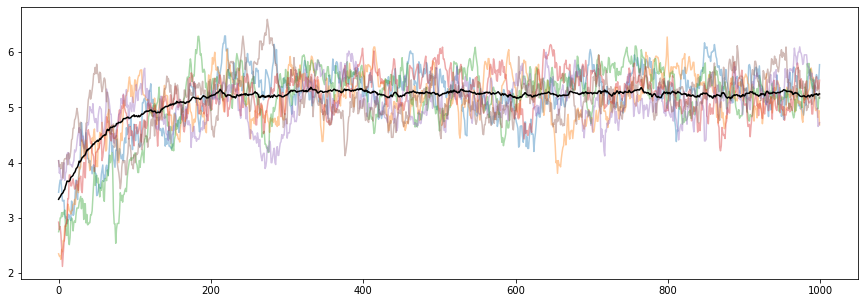

In [11]:
plt.figure(figsize=(15, 5))
CN = multsimNeighborCounts[:,1:7]/multsimCoralCounts[:,1:7]
CNmean = (multsimNeighborCounts/multsimCoralCounts).mean(axis=1)
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

# Simulation with Maximized Coral Neighborhood Blob

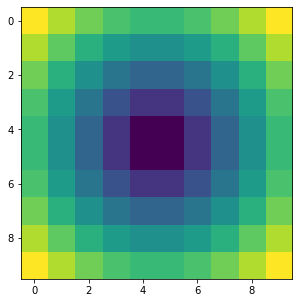

In [12]:
## distance to center mask
center = (round(rows/2),round(columns/2))
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
plt.figure(figsize=(15, 5))
plt.imshow(distanceGrid)

### Checking Initial Reef

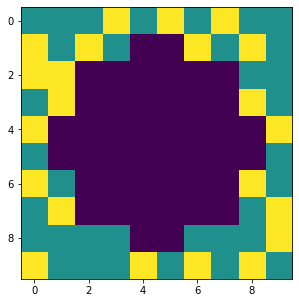

In [64]:
coralNodeLocations = (np.where(distanceGrid < np.median(distanceGrid)))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]
### Sudo Making of Initial Reef
grid = np.zeros((rows,columns))
for i in range(0,rows):        
    for j in range(0,columns):
        U = np.random.choice([1,2],
                             p=[.5, .5])
        if (i,j) in coralNodeLocations:
            U = 0
        grid[i,j] = U
plt.figure(figsize=(15, 5))
plt.imshow(grid)

## Model set-up/run with initial coral blob condition, coral at 50% 

In [15]:
## Simulations and Number of runs
NumberOfSimulations = 100
dt=.1
tf=100

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .5
algaePercent = .25

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.9
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent

## Specific Coral Nodes
center = (round(rows/2),round(columns/2))
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
coralNodeLocations = (np.where(distanceGrid < np.median(distanceGrid)))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [16]:
## Running Model
Resilient = Ocean()
for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    Resilient.append(optimalReef)

### Coral Node Count: 7 simulations and average of 100 simulations

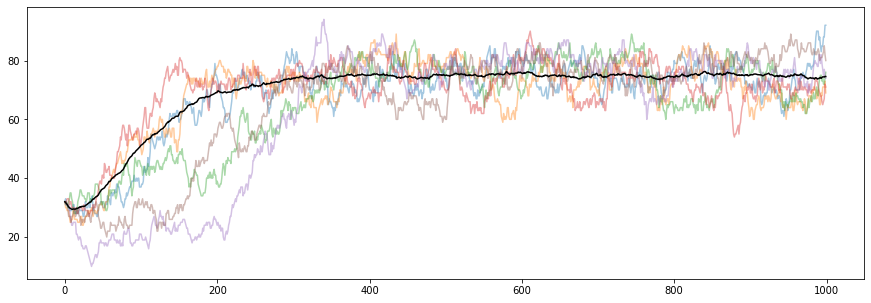

In [65]:
multsimCoralCounts = np.array([dictToNumpy(Resilient.simulation[i].coralNodeCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(Resilient.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()
##plotting
x = list(Resilient.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts[:,1:7], alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### CN index: 7 simulations and average of 100 simulations

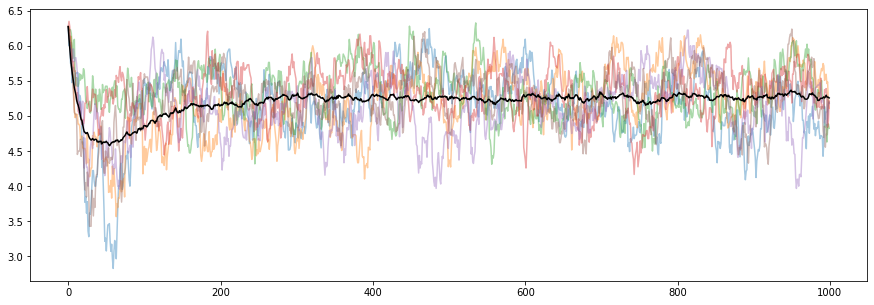

In [19]:
plt.figure(figsize=(15, 5))
CN = multsimNeighborCounts[:,1:7]/multsimCoralCounts[:,1:7]
CNmean = (multsimNeighborCounts/multsimCoralCounts).mean(axis=1)
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

## Model set-up/run with initial coral blob condition, coral at 33%

In [20]:
## Simulations and Number of runs
NumberOfSimulations = 100
dt=.1
tf=100

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.9
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent


## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [21]:
%%time
Resilient = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    Resilient.append(optimalReef)

CPU times: user 1min 10s, sys: 590 ms, total: 1min 11s
Wall time: 1min 11s


### Coral Node Count: 7 simulations and average of 100 simulations

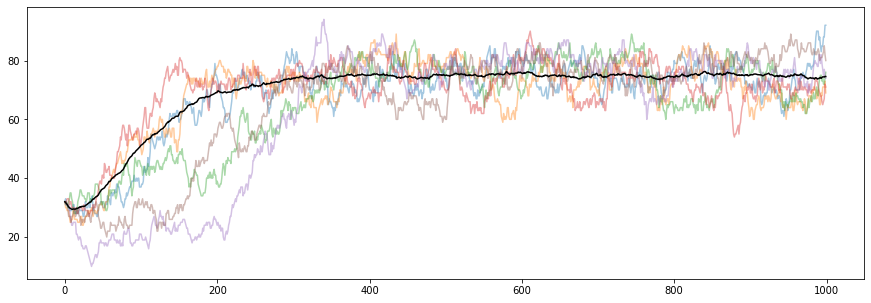

In [23]:
multsimCoralCounts = np.array([dictToNumpy(Resilient.simulation[i].coralNodeCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(Resilient.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(Pacific.simulation)]).transpose()
x = list(Resilient.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts[:,1:7], alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### CN index: 7 simulations and average of 100 simulations

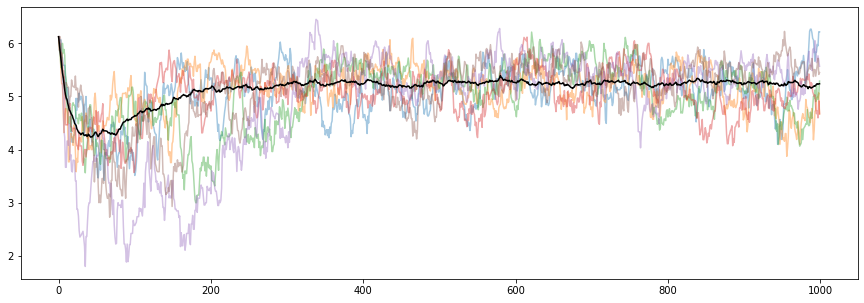

In [24]:
plt.figure(figsize=(15, 5))
CN = multsimNeighborCounts[:,1:7]/multsimCoralCounts[:,1:7]
CNmean = (multsimNeighborCounts/multsimCoralCounts).mean(axis=1)
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

## G parameter = .5, Model set-up/run with initial coral blob condition , coral at 33%


In [80]:
## Simulations and Number of runs
NumberOfSimulations = 100
dt=.1
tf=100

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.5
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent


## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [81]:
%%time
LowGrazing = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    LowGrazing.append(optimalReef)

CPU times: user 1min 1s, sys: 175 ms, total: 1min 1s
Wall time: 1min 2s


### Coral Node Count: 100 simulations and average of 100 simulations 

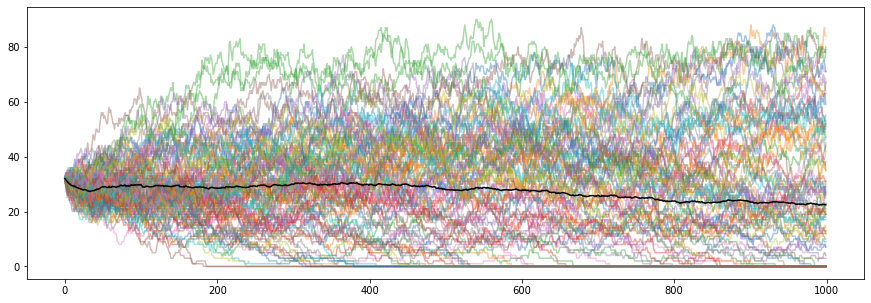

In [82]:
multsimCoralCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNodeCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()
x = list(LowGrazing.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts, alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### CN index: 100 simulations and average of 100 simulations

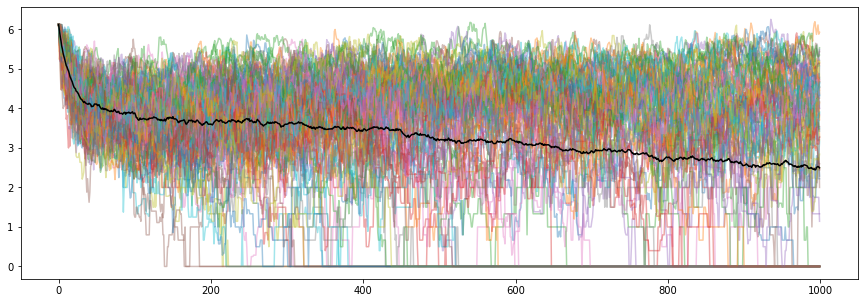

In [83]:
a = multsimNeighborCounts
b = multsimCoralCounts

CN = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
CNmean = CN.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

## Same as above but with more time steps, testing with less simulations

In [84]:
## Simulations and Number of runs
NumberOfSimulations = 10
dt=.1
tf=1000

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.5
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent


## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [85]:
%%time
LowGrazing = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    LowGrazing.append(optimalReef)

CPU times: user 1min 2s, sys: 363 ms, total: 1min 2s
Wall time: 1min 3s


In [86]:
multsimCoralCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNodeCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

### Coral Node Count: 10 simulations of 10,000 timesteps, and the average of the 10 simulations 

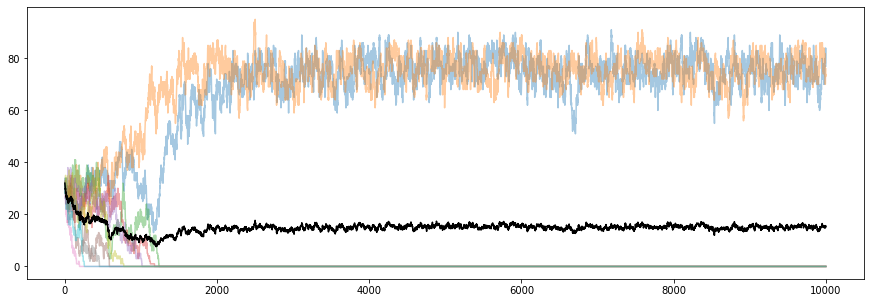

In [87]:
x = list(LowGrazing.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts, alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### ^^ For this one above it would be interesting to explore whether the spatial configuration for the two top lines allowed for coral success. 

### CN index: 10 simulations of 10,000 time steps, and the average of the 10 simulations

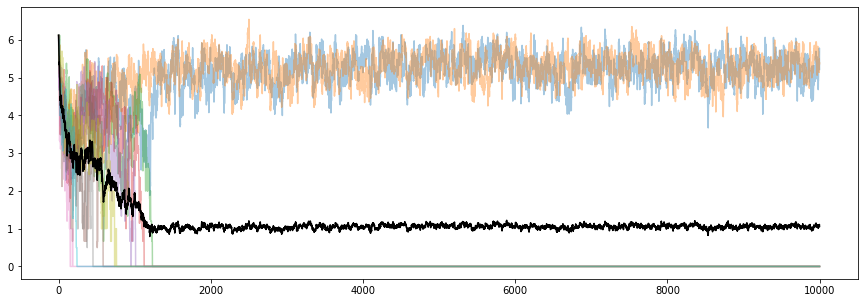

In [88]:
a = multsimNeighborCounts
b = multsimCoralCounts

CN = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
CNmean = CN.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

## G parameter = .2, more time steps, testing with less simulations

In [89]:
## Simulations and Number of runs
NumberOfSimulations = 10
dt=.1
tf=1000

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.2
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent


## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [90]:
%%time
LowGrazing = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    LowGrazing.append(optimalReef)

CPU times: user 57.9 s, sys: 369 ms, total: 58.2 s
Wall time: 58.7 s


In [91]:
multsimCoralCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNodeCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

### Coral Node Count: 10 simulations of 10,000 timesteps, and the average of the 10 simulations. Very grazing (g=.2)

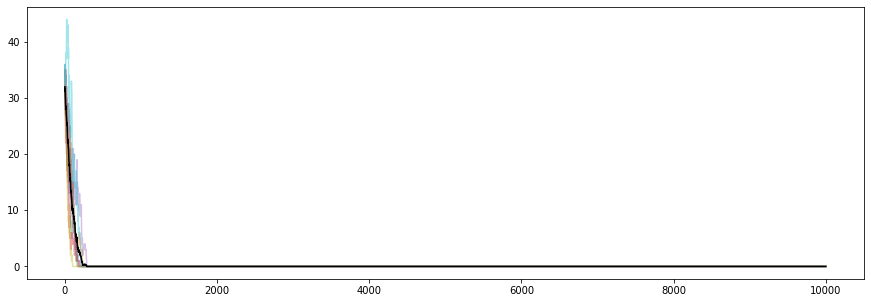

In [92]:
x = list(LowGrazing.simulation[1].coralNodeCount.keys())
plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts, alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

### Coral Node Count: 10 simulations of 10,000 timesteps, and the average of the 10 simulations. Very low grazing (g=.2)

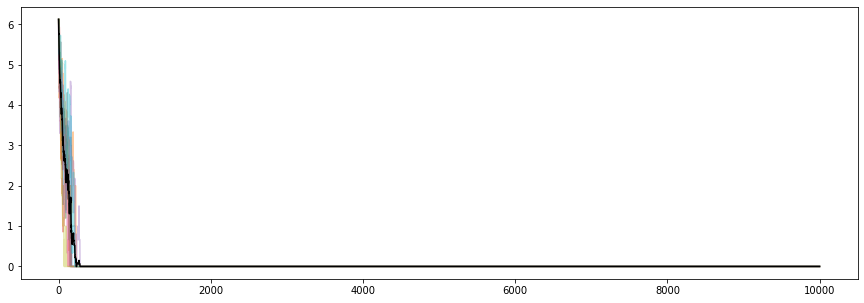

In [93]:
a = multsimNeighborCounts
b = multsimCoralCounts

CN = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
CNmean = CN.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

# -------  Looking at spatial evolution of g=.5 ---------

100

In [99]:
## Simulations and Number of runs
NumberOfSimulations = 10
dt=.1
tf=1000

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.5
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent

## Storing Spatial Grid, may slow down run
types = np.zeros((NumberOfTimesteps, NumberOfNodes, NumberOfSimulations))

## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [100]:
%%time
LowGrazing = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        for i,val in enumerate(Moorea.nodes): ##bug
            types[n,i,s] = Moorea.nodes[i].type ##bug
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    LowGrazing.append(optimalReef)

CPU times: user 1min 2s, sys: 1.61 s, total: 1min 4s
Wall time: 1min 4s


### Ran and plotted the above simulation set up twice to get the prefered results (shown below) I.e. reefs with the same initial conditions but drastically different outputs to investigate potential spatially resilient reefs

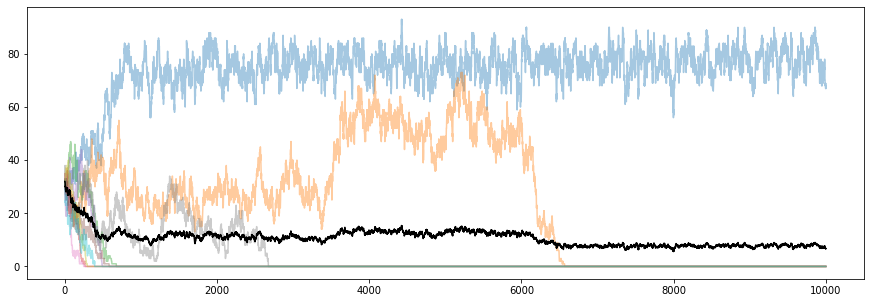

In [101]:
x = list(LowGrazing.simulation[1].coralNodeCount.keys())

multsimCoralCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNodeCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(LowGrazing.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(LowGrazing.simulation)]).transpose()

plt.figure(figsize=(15, 5))
plt.plot(x,multsimCoralCounts, alpha=0.4)
plt.plot(x,multsimCoralCounts.mean(axis=1), 'black')

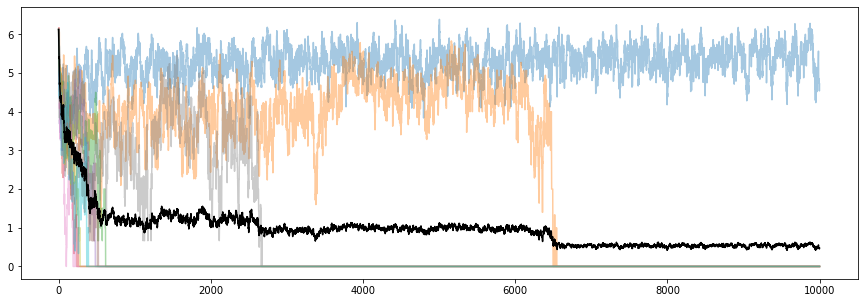

In [167]:
a = multsimNeighborCounts
b = multsimCoralCounts

CN = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
CNmean = CN.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

### First saving the Ocean() class object (LowGrazing), and the grid evolution of each simulation (saved in types) for furture use, later commented out to avoid overwriting

In [107]:
# Save types, i.e. all the grid progression data
#for i in range(0,len(LowGrazing.simulation)):
#    np.savetxt("coralModelTrackingOutputs/modelOutput_switching"+ str(i)+".csv", 
#               np.reshape(types[:,:,i], (-1, rows)), delimiter=",")

In [108]:
#import pickle
#path = 'coralModelTrackingOutputs//'
#output_name = 'grazing5'
#outfile = open(path+output_name, "wb")       #open pickle jar
#pickle.dump(LowGrazing, outfile)           #put contents into jar
#outfile.close()                         #close the jar

#PacificReturns = pickle.loads(open(path+output_name, "rb").read())

### Exploring individual bands, seeing which simulation at which time, and plotting the grids at those specific times

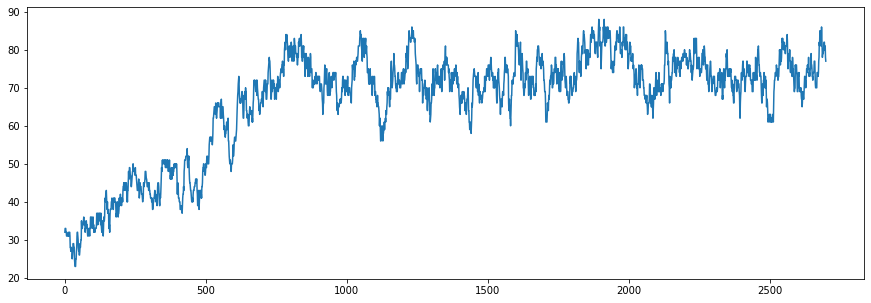

In [177]:
explorer = LowGrazing.simulation[0].coralNodeCount
x = list(explorer.keys())            ## the time steps
coralCount = list(explorer.values()) ## the number of coral nodes

plt.figure(figsize=(15, 5))
plt.plot(x[0:2700],coralCount[0:2700])

### Conclusions from playing with plot above:

* **Blue line**
* simulation 0, reaches general consistency starting around 700

* **Orange line**
* simulation 1, drops at time 5985, from time 6150-6200 huge decline, reaches 0 at time = 6567. recovery period from 3300 - 3400. 


* **Lilac/Gray line**
* simulation 7, drops slowly from time 0-2700. rises "briefly", from 1100-1400.

* **Ambiguous early crashers** = 
* simulation 2, crashes from approx 300 - 700, 
* simulation 3, crashed from 10 - 260, 
* simulation 4, crashes from 210-500
* simulation 5, crashes from 100 - 600
* simulation 6, crashes from 100 - 250
* simulation 8, crashes from 40 - 300
* simulation 9, crashed from 0-400







### One task for tomorrow: run these grid configurations again and see if how their outputs vary (maybe this is where to include the variance)



# ------ Just realized the spatial products weren't saved properly (graphs above are accurate but did not store spatial evolution, will do tomorrow with another run of all the simulations) ----

In [272]:
def timeSeriesPlotter(item=LowGrazing.simulation[0], title=''):
    x = list(item.coralNodeCount.keys())            ## the time steps
    CoralCounts = np.array([dictToNumpy(
        item.coralNodeCount)]).transpose()
    NeighborCounts = np.array([dictToNumpy(
        item.coralNeighborCount)]).transpose()
    a = NeighborCounts
    b = CoralCounts
    CN = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(311)
    plt.plot(x,CoralCounts, alpha = .5)
    plt.ylabel('Coral Node Count')


    plt.title(title, fontsize=12, fontweight = 'bold')
    plt.subplot(312)
    plt.ylabel('CN Index')
    plt.xlabel('Time')
    
    plt.subplot(313)
    plt.ylabel('CNr Index')
    plt.xlabel('Time')

    plt.plot(x, CN, alpha = .5)

    
def shaper(df, rows):
    df = np.reshape(df, (-1, rows))
    return(df)
    

## Glance into simulation 0, blue line that reaches consistency in the difficult (low grazing) conditions

TypeError: 'str' object is not callable

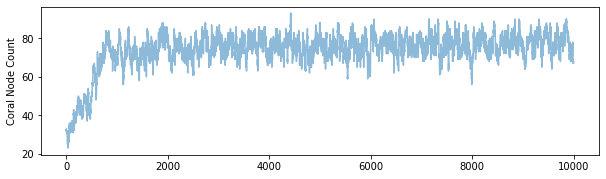

In [357]:
timeSeriesPlotter(item=LowGrazing.simulation[0], title="Consistent at grazing =.5")

## Glance into simulation 1, orange line that reaches consistency in the difficult (low grazing) conditions

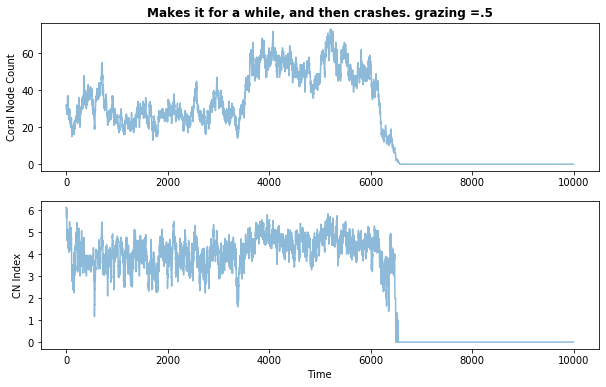

In [190]:
timeSeriesPlotter(item=LowGrazing.simulation[1], 
                  title="Makes it for a while, and then crashes. grazing =.5")

In [ ]:
# simulation 1, drops at time 5985, from time 6150-6200 huge decline, 
# reaches 0 at time = 6567. recovery period from 3300 - 3400. 
initialFinal(item=types, simulation=1, 
                 timesteps=[3299,3350,3400,
                            5,6,7,
                            8,9,10])

## Glance into simulation 7, drops slowly with a brief rise

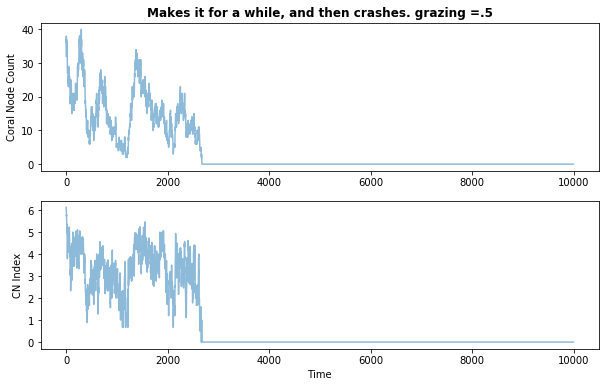

In [192]:
timeSeriesPlotter(item=LowGrazing.simulation[7], 
                  title="Makes it for a while, and then crashes. grazing =.5")

# --  30 SIMULATIONS, GRAZING .5, SPATIAL PLOTS ---

In [412]:
def timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x, simulation=0,title=''):  
    plt.figure(figsize=(10, 6))
    plt.subplot(311)
    plt.plot(x, C[:,simulation], alpha = .5)
    plt.ylabel('Coral Node Count')

    plt.subplot(312)
    plt.ylabel('CN Index')
    plt.xlabel('Time')
    plt.plot(x, CN[:,simulation], alpha = .5)
    
    plt.subplot(313)
    plt.ylabel('CNr Index')
    plt.xlabel('Time')
    plt.plot(x, CNr[:,simulation], alpha = .5)

def initialFinal9(types=types, C=C, CN=CN, CNr=CNr, simulation=1, 
                 timesteps=[0,1,2,3,4,5,6,7,8,9,10,11,12]):
    plt.figure(figsize=(15, 12))

    #colors = ['pink', 'lightgreen','darkgreen']
    #levels = [0, 1, 2]
    #cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
    
    plt.subplot(331).set_title('-C-  ' + str(C[timesteps[0],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[0],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[0],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[0],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    plt.subplot(332).set_title('-C-  ' + str(C[timesteps[1],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[1],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[1],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[1],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    plt.subplot(333).set_title('-C-  ' + str(C[timesteps[2],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[2],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[2],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[2],:,simulation],10), 
               cmap=cmap, norm=norm)  
    
    plt.subplot(334).set_title('-C-  ' + str(C[timesteps[3],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[3],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[0],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[3],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    plt.subplot(335).set_title('-C-  ' + str(C[timesteps[4],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[4],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[4],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[4],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    
    plt.subplot(336).set_title('-C-  ' + str(C[timesteps[5],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[5],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[5],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[5],:,simulation],10), 
               cmap=cmap, norm=norm) 
    
    
    plt.subplot(337).set_title('-C-  ' + str(C[timesteps[6],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[6],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[6],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[6],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    
    plt.subplot(338).set_title('-C-  ' + str(C[timesteps[7],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[7],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[7],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[7],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    
    plt.subplot(339).set_title('-C-  ' + str(C[timesteps[8],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[8],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[8],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[8],:,simulation],10), 
               cmap=cmap, norm=norm)
    plt.show()

def initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=1, 
                 timesteps=[0,1,2]):
    plt.figure(figsize=(15, 4))

    #colors = ['pink', 'lightgreen','darkgreen']
    #levels = [0, 1, 2]
    #cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
    
    plt.subplot(131).set_title('-C-  ' + str(C[timesteps[0],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[0],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[0],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[0],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    plt.subplot(132).set_title('-C-  ' + str(C[timesteps[1],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[1],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[1],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[1],:,simulation],10), 
               cmap=cmap, norm=norm)
    
    plt.subplot(133).set_title('-C-  ' + str(C[timesteps[2],simulation])+
                              '  -CN-  ' + str(round(CN[timesteps[2],simulation],2))+
                              '  -CNr-  ' + str(round(CNr[timesteps[2],simulation],2)),
                              fontweight="bold")
    plt.imshow(shaper(types[timesteps[2],:,simulation],10), 
               cmap=cmap, norm=norm)  
    plt.show()

In [266]:
## Simulations and Number of runs
NumberOfSimulations = 30
dt=.1
tf=1000

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages
coralPercent = .33
algaePercent = .33

## Parameters
r=1.0
d=.4 #.2
a=.2
g=.5
y=.75 #.9

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent

## Storing Spatial Grid, may slow down run
#types = np.zeros((NumberOfTimesteps, NumberOfNodes, NumberOfSimulations))

## Distance Prep
distanceGrid = np.array([Reef.distance([i+.5,j+.5], center) 
                 for i in range(0,rows) 
                 for j in range(0,columns)]).reshape(rows,columns)
maxCoralDist = np.concatenate(distanceGrid, axis=None)
maxCoralDist = np.sort(maxCoralDist)[33]

coralNodeLocations = (np.where(distanceGrid < maxCoralDist))
coralNodeLocations = [(coralNodeLocations[0][n],coralNodeLocations[1][n]) 
                      for n in range(0,len(coralNodeLocations[0]))]

In [267]:
%%time
#Switching = Ocean()

for s in range(0,NumberOfSimulations):

    optimalReef = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([1,2],
                                 p=[.5, .5])
            if (i,j) in coralNodeLocations:
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            optimalReef.append(node)
            count = count + 1            
    optimalReef.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        
        for i,val in enumerate(optimalReef.nodes):
            types[n,i,s] = optimalReef.nodes[i].type
        optimalReef.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    Switching.append(optimalReef)

CPU times: user 3min 26s, sys: 764 ms, total: 3min 27s
Wall time: 3min 28s


In [274]:
# Save types, i.e. all the grid progression data
#for i in range(0,len(Switching.simulation)):
#    np.savetxt("coralModelTrackingOutputs /modelOutput_switching"+ str(i)+".csv", 
#               np.reshape(types[:,:,i], (-1, rows)), delimiter=",")

In [275]:
#import pickle
#path = 'coralModelTrackingOutputs //'
#output_name = 'grazing5'
#outfile = open(path+output_name, "wb")       #open pickle jar
#pickle.dump(Switching, outfile)           #put contents into jar
#outfile.close()                         #close the jar

#PacificReturns = pickle.loads(open(path+output_name, "rb").read())

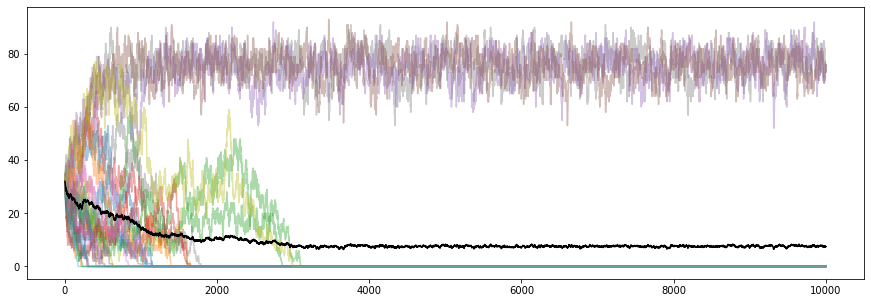

In [350]:
x = list(Switching.simulation[1].coralNodeCount.keys())

multsimCoralCounts = np.array([dictToNumpy(Switching.simulation[i].coralNodeCount) 
                               for i,val in enumerate(Switching.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(Switching.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(Switching.simulation)]).transpose()
C = multsimCoralCounts
N = multsimNeighborCounts

plt.figure(figsize=(15, 5))
plt.plot(x,C, alpha=0.4)
plt.plot(x,C.mean(axis=1), 'black')

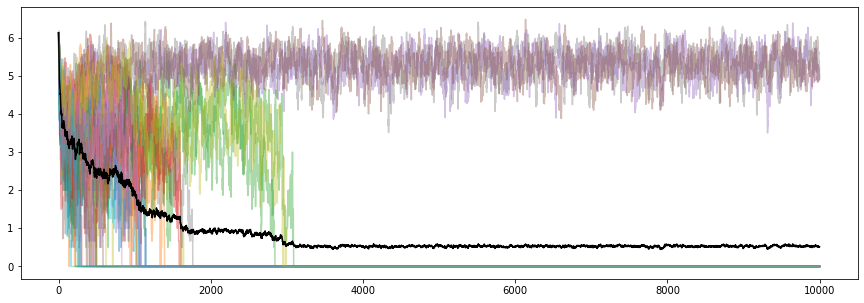

In [351]:
CN = np.divide(N, C, out=np.zeros_like(a), where=b!=0)
CNmean = CN.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CN, alpha=0.4)
plt.plot(x, CNmean, 'black')

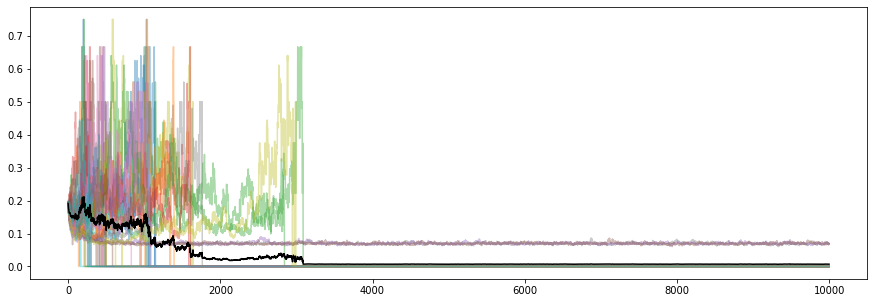

In [352]:
CNr = np.divide(CN, C, out=np.zeros_like(a), where=b!=0)
CNrmean = CNr.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x, CNr, alpha=0.4)
plt.plot(x, CNrmean, 'black')

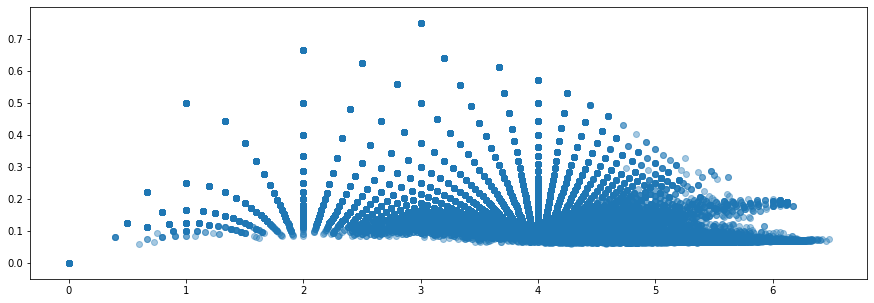

In [353]:
plt.figure(figsize=(15, 5))
plt.scatter(CN, CNr, alpha=0.4)
#plt.plot(x, CNrmean, 'black')

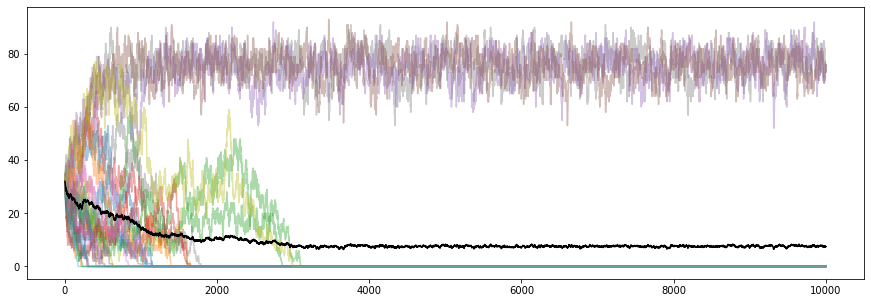

In [376]:
x = list(Switching.simulation[1].coralNodeCount.keys())

multsimCoralCounts = np.array([dictToNumpy(Switching.simulation[i].coralNodeCount) 
                               for i,val in enumerate(Switching.simulation)]).transpose()

multsimNeighborCounts = np.array([dictToNumpy(Switching.simulation[i].coralNeighborCount) 
                               for i,val in enumerate(Switching.simulation)]).transpose()
C = multsimCoralCounts
N = multsimNeighborCounts

plt.figure(figsize=(15, 5))
plt.plot(x,C, alpha=0.4)
plt.plot(x,C.mean(axis=1), 'black')

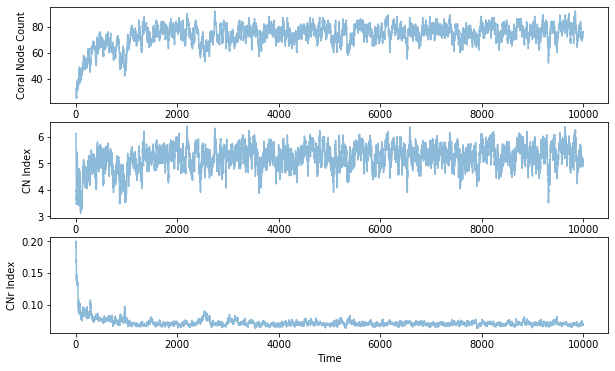

In [409]:
timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x,simulation=14, 
                  title="Makes it for a while, and then crashes. grazing =.5")

### Conclusions from playing with plot above:

* **Lives On**
* simulation 7:400, 14:1100, 25:900

* **Mid Crash**
* simulation 2:2300-3000, 22:3000, 28:3000
    
* **EarlyMid Crash** 
* simulation 8:1800, 13:1700, 17:1800, 21, 23

* **Ambiguous early crashers** 
* simulation 0:1000, 1:300, 3:400, 4:300, 5:800, 6, 9, 10, 11, 12, 15, 16, 18, 19, 20, 24, 26, 27, 29
### One task for tomorrow: run these grid configurations again and see if how their outputs vary (maybe this is where to include the variance)

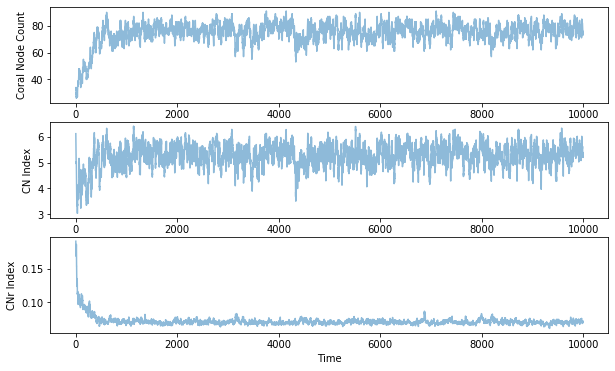

In [410]:
timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x,simulation=7, 
                  title="Makes it for a while, and then crashes. grazing =.5")

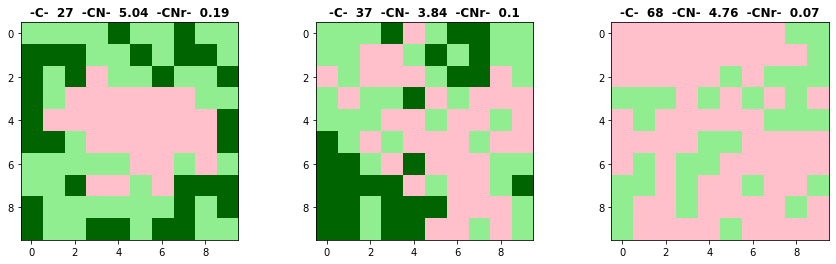

In [413]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=7, 
                 timesteps=[10,100,500])

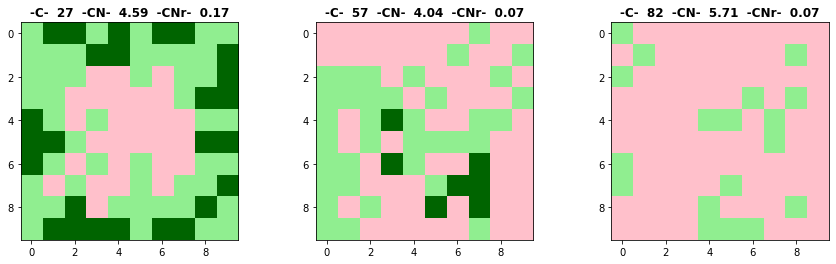

In [414]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=14, 
                 timesteps=[10,1000,2000])

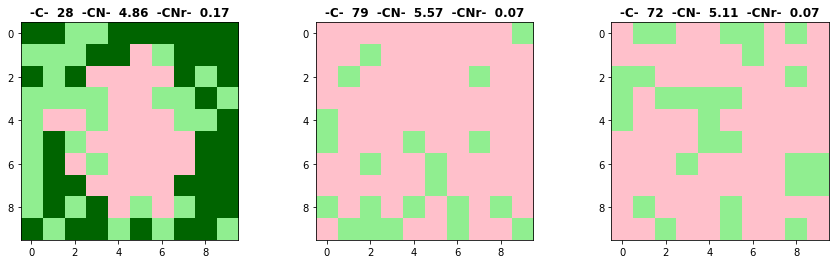

In [416]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=25, 
                 timesteps=[10,700,1000])

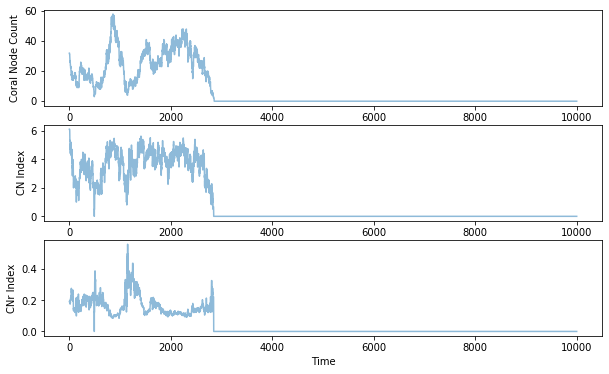

In [417]:
timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x,simulation=2, 
                  title="Makes it for a while, and then crashes. grazing =.5")

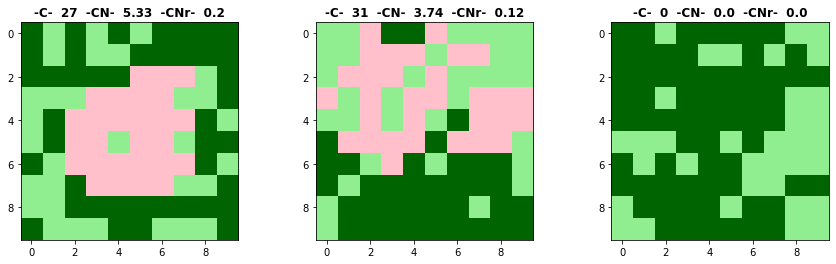

In [425]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=2, 
                 timesteps=[10,2000,3000])

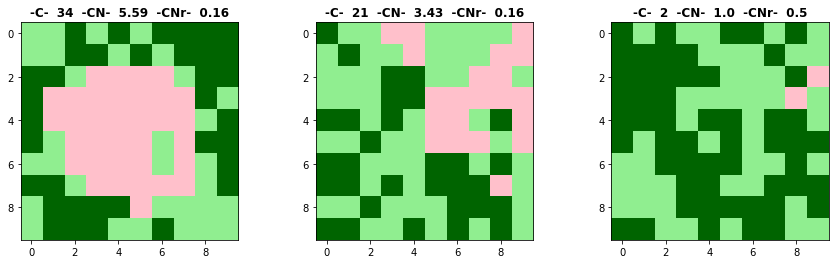

In [426]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=22, 
                 timesteps=[10,2000,3000])

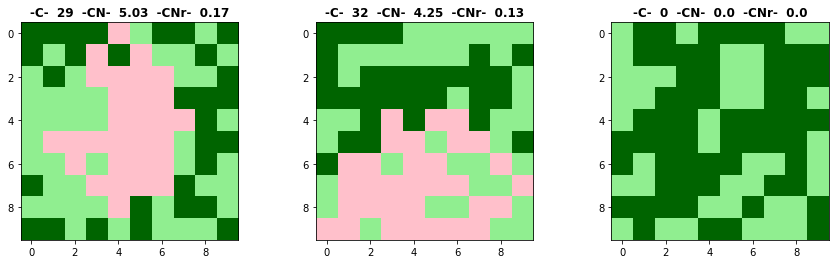

In [427]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=28, 
                 timesteps=[10,2000,3000])

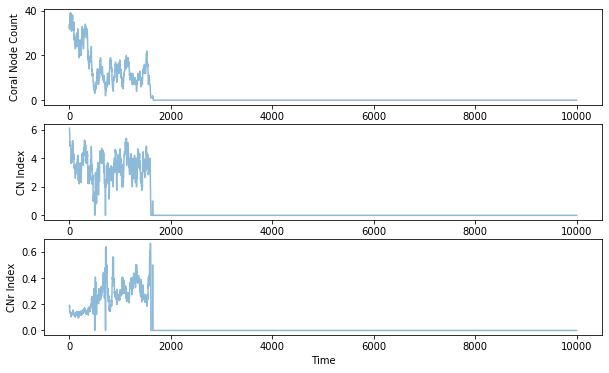

In [428]:
timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x,simulation=8, 
                  title="Makes it for a while, and then crashes. grazing =.5")

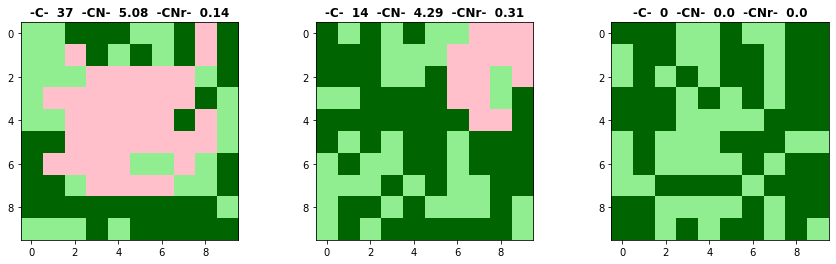

In [429]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=8, 
                 timesteps=[10,1000,2000])

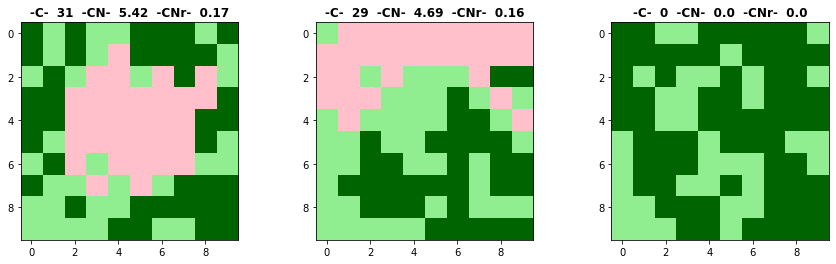

In [430]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=13, 
                 timesteps=[10,1000,2000])

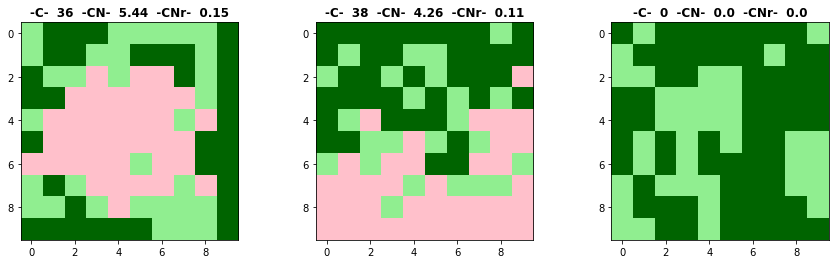

In [431]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=17, 
                 timesteps=[10,1000,2000])

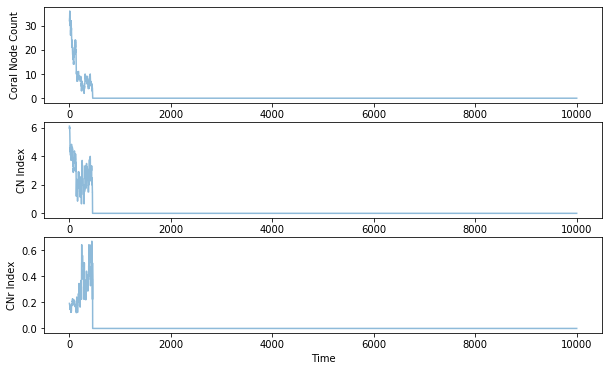

In [432]:
timeSeriesPlotter(C=C,CN=CN,CNr=CNr,x=x,simulation=6, 
                  title="Makes it for a while, and then crashes. grazing =.5")

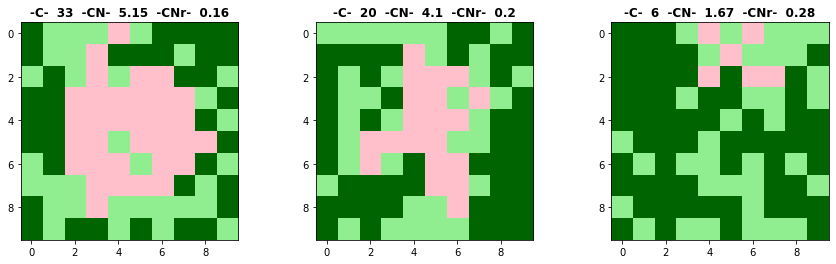

In [437]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=6, 
                 timesteps=[10,100,300])

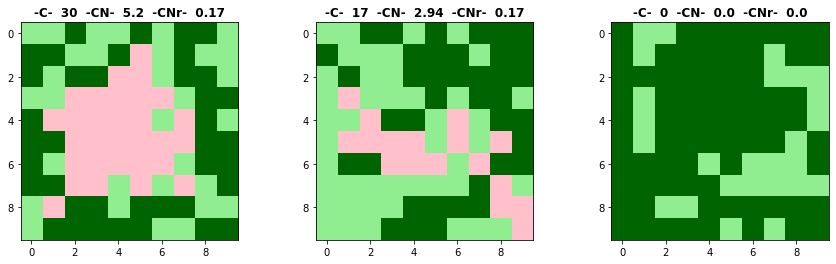

In [438]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=9, 
                 timesteps=[10,100,300])

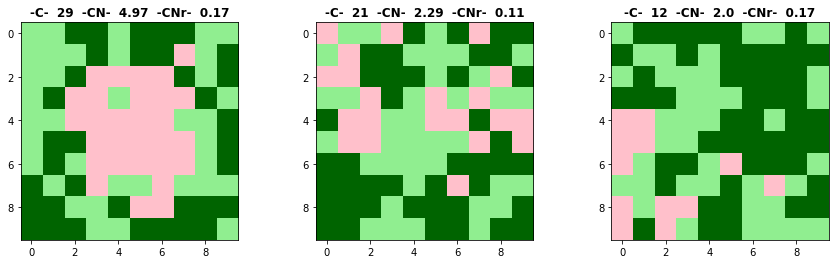

In [439]:
initialFinal3(types=types, C=C, CN=CN, CNr=CNr, simulation=10, 
                 timesteps=[10,100,300])

In [ ]:

#### Will play with another time


## run selectively with specific runs --- make good titles in video that explains relevance

import matplotlib.animation as animation
#from IPython.display import HTML

fig = plt.figure("Moving Wavepackage")
colors = ['pink', 'lightgreen','darkgreen']
levels = [0, 1, 2]
cmap, norm = clt.from_levels_and_colors(levels=levels,
                                        colors=colors, 
                                        extend='max')

Z   = []
img = []
for i in range(NumberOfTimesteps):
    Z.append(np.reshape(types[i,:,0], (-1, rows)))
    img.append([plt.imshow(Z[i], cmap=cmap, norm=norm)])
    
#anim = animation.ArtistAnimation(fig, img, interval=200, blit=True, repeat_delay=0)
#HTML(anim.to_html5_video())
#anim.save('coralModelTrackingOutputs/movie0.gif', writer='imagemagick', fps=5)
